In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [4]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [35]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [23]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [24]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [25]:
df = df['2021-10-28']
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-10-28 00:00:00,23.85,53.88,2.00,3.00,0.0,0.0,457.68,0.0
2021-10-28 00:05:00,23.87,53.88,2.29,3.29,0.0,0.0,457.62,0.0
2021-10-28 00:10:00,23.84,53.82,2.43,3.43,0.0,0.0,456.57,0.0
2021-10-28 00:15:00,23.81,53.77,2.00,3.00,0.0,0.0,456.17,0.0
2021-10-28 00:20:00,23.80,53.83,2.00,3.00,0.0,0.0,455.89,0.0
...,...,...,...,...,...,...,...,...
2021-10-28 23:35:00,23.80,54.93,6.86,7.86,0.0,0.0,456.89,0.0
2021-10-28 23:40:00,23.81,54.90,6.62,7.62,0.0,0.0,456.01,0.0
2021-10-28 23:45:00,23.76,54.88,6.50,7.50,0.0,0.0,455.67,0.0


In [26]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-10-28 00:00:00,23.85,53.88,2.00,3.00,457.68
2021-10-28 00:05:00,23.87,53.88,2.29,3.29,457.62
2021-10-28 00:10:00,23.84,53.82,2.43,3.43,456.57
2021-10-28 00:15:00,23.81,53.77,2.00,3.00,456.17
2021-10-28 00:20:00,23.80,53.83,2.00,3.00,455.89
...,...,...,...,...,...
2021-10-28 23:35:00,23.80,54.93,6.86,7.86,456.89
2021-10-28 23:40:00,23.81,54.90,6.62,7.62,456.01
2021-10-28 23:45:00,23.76,54.88,6.50,7.50,455.67


In [27]:
df_lags_5 = lags(df_final, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,3.00,3.43,3.29,3.00,455.89,456.17,456.57,457.62,457.68,455.26
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,3.00,3.00,3.43,3.29,455.26,455.89,456.17,456.57,457.62,453.98
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,3.00,3.00,3.00,3.43,453.98,455.26,455.89,456.17,456.57,453.58
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,3.00,3.00,3.00,3.00,453.58,453.98,455.26,455.89,456.17,453.01
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,2.86,3.00,3.00,3.00,453.01,453.58,453.98,455.26,455.89,451.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,8.29,8.50,9.00,9.17,456.20,455.95,455.85,456.74,457.30,456.89
279,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,8.25,8.29,8.50,9.00,456.89,456.20,455.95,455.85,456.74,456.01
280,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,7.86,8.25,8.29,8.50,456.01,456.89,456.20,455.95,455.85,455.67
281,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,7.62,7.86,8.25,8.29,455.67,456.01,456.89,456.20,455.95,455.66


In [28]:
df_lags_10 = lags(df_final, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,457.68,451.02
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,450.60
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,450.83
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,449.44
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,450.83,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,449.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,455.95,455.85,456.74,457.30,457.95,459.39,459.33,459.07,459.59,456.89
274,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,456.20,455.95,455.85,456.74,457.30,457.95,459.39,459.33,459.07,456.01
275,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,456.89,456.20,455.95,455.85,456.74,457.30,457.95,459.39,459.33,455.67
276,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,456.01,456.89,456.20,455.95,455.85,456.74,457.30,457.95,459.39,455.66


In [29]:
df_lags_15 = lags(df_final, 15) #predecir a 15 minutos
df_lags_15 = df_lags_15.iloc[15:,:].reset_index(drop=True)
df_lags_15

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,Lag_co2_11,Lag_co2_12,Lag_co2_13,Lag_co2_14,Lag_co2_15,co2
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,457.68,449.43
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,457.62,449.01
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,456.57,448.22
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,456.17,448.05
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,450.83,450.60,451.02,451.59,453.01,453.58,453.98,455.26,455.89,447.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,459.39,459.33,459.07,459.59,460.81,461.43,462.09,462.75,463.05,456.89
269,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,457.95,459.39,459.33,459.07,459.59,460.81,461.43,462.09,462.75,456.01
270,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,457.30,457.95,459.39,459.33,459.07,459.59,460.81,461.43,462.09,455.67
271,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,456.74,457.30,457.95,459.39,459.33,459.07,459.59,460.81,461.43,455.66


# Linear Regression

## 5 minutos

Test Score Step 1
RMSE 9.74
MAE 7.29
Test Score Step 2
RMSE 14.13
MAE 10.70
Test Score Step 3
RMSE 18.70
MAE 14.26
Test Score Step 4
RMSE 23.76
MAE 18.18
Test Score Step 5
RMSE 28.63
MAE 21.93


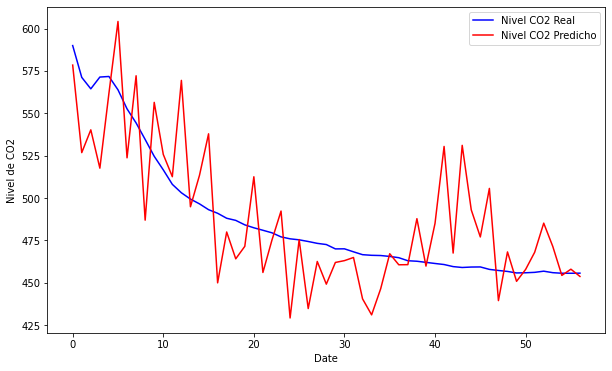

In [36]:
rmse_5, mae_5, preds_5 = testCO2Quality(df_lags_5, 5, LinearRegression())

## 10 minutos

Test Score Step 1
RMSE 21.09
MAE 16.92
Test Score Step 2
RMSE 28.93
MAE 23.10
Test Score Step 3
RMSE 37.79
MAE 30.26
Test Score Step 4
RMSE 48.87
MAE 39.21
Test Score Step 5
RMSE 60.74
MAE 47.89
Test Score Step 6
RMSE 73.78
MAE 57.93
Test Score Step 7
RMSE 83.06
MAE 65.34
Test Score Step 8
RMSE 88.45
MAE 69.49
Test Score Step 9
RMSE 94.39
MAE 73.99
Test Score Step 10
RMSE 100.62
MAE 78.66


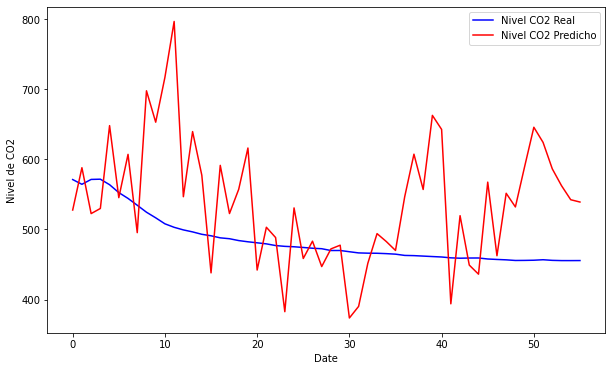

In [37]:
rmse_10, mae_10, preds_10 = testCO2Quality(df_lags_10, 10, LinearRegression())

## 15 minutos

Test Score Step 1
RMSE 25.27
MAE 20.49
Test Score Step 2
RMSE 34.06
MAE 27.01
Test Score Step 3
RMSE 44.78
MAE 35.63
Test Score Step 4
RMSE 58.15
MAE 46.60
Test Score Step 5
RMSE 72.42
MAE 58.19
Test Score Step 6
RMSE 89.44
MAE 71.25
Test Score Step 7
RMSE 102.45
MAE 80.81
Test Score Step 8
RMSE 110.69
MAE 87.67
Test Score Step 9
RMSE 120.43
MAE 95.80
Test Score Step 10
RMSE 129.22
MAE 102.87
Test Score Step 11
RMSE 135.90
MAE 108.01
Test Score Step 12
RMSE 138.01
MAE 109.58
Test Score Step 13
RMSE 138.63
MAE 110.50
Test Score Step 14
RMSE 139.27
MAE 111.40
Test Score Step 15
RMSE 140.39
MAE 112.32


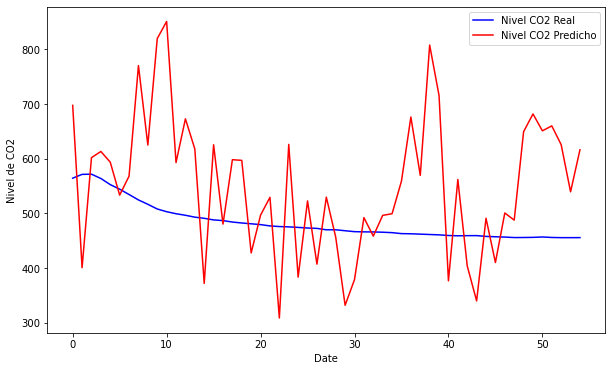

In [38]:
rmse_15, mae_15, preds_15 = testCO2Quality(df_lags_15, 15, LinearRegression())

# Random Forest

Test Score Step 1
RMSE 16.55
MAE 11.82
Test Score Step 2
RMSE 18.48
MAE 13.52
Test Score Step 3
RMSE 19.75
MAE 14.63
Test Score Step 4
RMSE 21.24
MAE 15.75
Test Score Step 5
RMSE 22.21
MAE 16.96


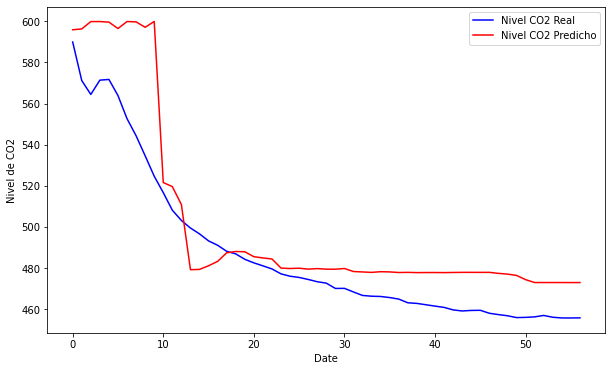

In [39]:
rmse_rf_5, mae_rf_5, preds_rf_5 = testCO2Quality(df_lags_5, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 19.50
MAE 13.02
Test Score Step 2
RMSE 23.72
MAE 15.85
Test Score Step 3
RMSE 29.04
MAE 18.68
Test Score Step 4
RMSE 36.78
MAE 22.02
Test Score Step 5
RMSE 46.15
MAE 26.34
Test Score Step 6
RMSE 49.50
MAE 28.44
Test Score Step 7
RMSE 51.93
MAE 29.87
Test Score Step 8
RMSE 52.79
MAE 30.34
Test Score Step 9
RMSE 53.15
MAE 30.54
Test Score Step 10
RMSE 53.91
MAE 30.90


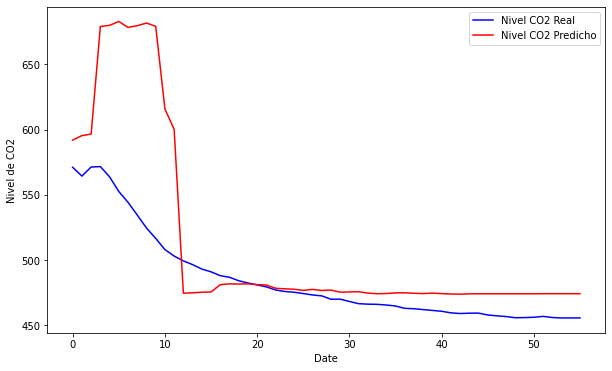

In [40]:
rmse_rf_10, mae_rf_10, preds_rf_10 = testCO2Quality(df_lags_10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 21.80
MAE 16.16
Test Score Step 2
RMSE 25.76
MAE 18.08
Test Score Step 3
RMSE 31.14
MAE 20.56
Test Score Step 4
RMSE 34.79
MAE 22.37
Test Score Step 5
RMSE 38.19
MAE 23.75
Test Score Step 6
RMSE 39.10
MAE 24.34
Test Score Step 7
RMSE 42.42
MAE 26.30
Test Score Step 8
RMSE 45.87
MAE 28.48
Test Score Step 9
RMSE 48.61
MAE 30.09
Test Score Step 10
RMSE 50.95
MAE 31.27
Test Score Step 11
RMSE 53.78
MAE 32.51
Test Score Step 12
RMSE 57.01
MAE 33.78
Test Score Step 13
RMSE 58.83
MAE 34.47
Test Score Step 14
RMSE 58.79
MAE 34.43
Test Score Step 15
RMSE 58.87
MAE 34.46


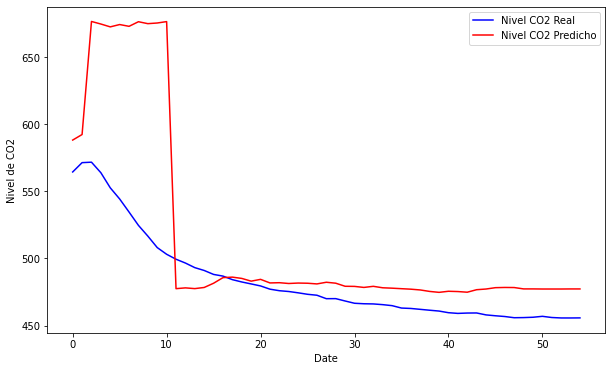

In [41]:
rmse_rf_15, mae_rf_15, preds_rf_15 = testCO2Quality(df_lags_15, 15, RandomForestRegressor(random_state=seed_value))

# PM2.5

In [42]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm25 = np.sum([len(re.findall("Lag_pm25*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm25], prueba_X_test.iloc[:,-lagspm25:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm25_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [43]:
def testPM25Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm25'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM2.5 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM2.5 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM2.5')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [44]:
df_final_pm25 = df_final[['temperature', 'relativehumidity', 'pm10', 'co2', 'pm25']]

In [47]:
df_lags_5_pm25 = lags(df_final_pm25, 5) #predecir a 5 minutos
df_lags_5_pm25 = df_lags_5_pm25.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,pm25
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,456.17,456.57,457.62,457.68,2.00,2.00,2.43,2.29,2.00,2.00
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,455.89,456.17,456.57,457.62,2.00,2.00,2.00,2.43,2.29,2.00
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,455.26,455.89,456.17,456.57,2.00,2.00,2.00,2.00,2.43,1.86
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,453.98,455.26,455.89,456.17,1.86,2.00,2.00,2.00,2.00,2.12
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,453.58,453.98,455.26,455.89,2.12,1.86,2.00,2.00,2.00,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,455.95,455.85,456.74,457.30,7.25,7.29,7.50,8.00,8.17,6.86
279,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,456.20,455.95,455.85,456.74,6.86,7.25,7.29,7.50,8.00,6.62
280,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,456.89,456.20,455.95,455.85,6.62,6.86,7.25,7.29,7.50,6.50
281,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,456.01,456.89,456.20,455.95,6.50,6.62,6.86,7.25,7.29,6.86


In [48]:
df_lags_10_pm25 = lags(df_final_pm25, 10) #predecir a 10 minutos
df_lags_10_pm25 = df_lags_10_pm25.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,Lag_pm25_6,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,pm25
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,2.00,1.86
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,1.75
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,1.75
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,1.43
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,1.75,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,7.29,7.50,8.00,8.17,8.62,9.33,10.00,9.88,10.43,6.86
274,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,7.25,7.29,7.50,8.00,8.17,8.62,9.33,10.00,9.88,6.62
275,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,6.86,7.25,7.29,7.50,8.00,8.17,8.62,9.33,10.00,6.50
276,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,6.62,6.86,7.25,7.29,7.50,8.00,8.17,8.62,9.33,6.86


In [49]:
df_lags_15_pm25 = lags(df_final_pm25, 15) #predecir a 15 minutos
df_lags_15_pm25 = df_lags_15_pm25.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,Lag_pm25_11,Lag_pm25_12,Lag_pm25_13,Lag_pm25_14,Lag_pm25_15,pm25
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,2.00,1.57
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,2.29,1.38
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,2.43,1.50
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,2.00,1.71
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,1.75,1.75,1.86,1.62,2.12,1.86,2.00,2.00,2.00,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,9.33,10.00,9.88,10.43,10.12,9.88,9.57,7.88,6.88,6.86
269,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,8.62,9.33,10.00,9.88,10.43,10.12,9.88,9.57,7.88,6.62
270,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,8.17,8.62,9.33,10.00,9.88,10.43,10.12,9.88,9.57,6.50
271,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,8.00,8.17,8.62,9.33,10.00,9.88,10.43,10.12,9.88,6.86


## Linear Regression

Test Score Step 1
RMSE 0.60
MAE 0.41
Test Score Step 2
RMSE 0.59
MAE 0.40
Test Score Step 3
RMSE 0.60
MAE 0.41
Test Score Step 4
RMSE 0.62
MAE 0.42
Test Score Step 5
RMSE 0.62
MAE 0.42


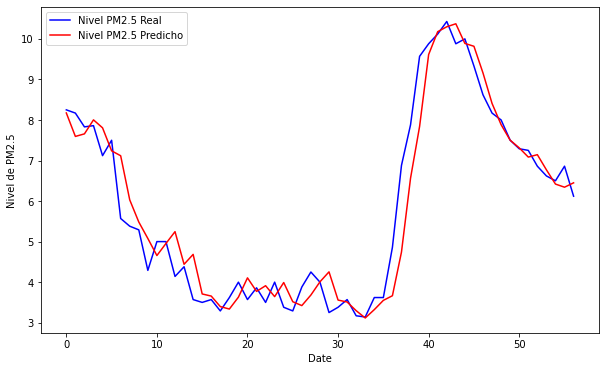

In [50]:
rmse_lr_5_pm25, mae_lr_5_pm25, preds_lr_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, LinearRegression())

Test Score Step 1
RMSE 0.62
MAE 0.43
Test Score Step 2
RMSE 0.61
MAE 0.43
Test Score Step 3
RMSE 0.63
MAE 0.44
Test Score Step 4
RMSE 0.65
MAE 0.44
Test Score Step 5
RMSE 0.64
MAE 0.44
Test Score Step 6
RMSE 0.64
MAE 0.44
Test Score Step 7
RMSE 0.64
MAE 0.44
Test Score Step 8
RMSE 0.65
MAE 0.45
Test Score Step 9
RMSE 0.65
MAE 0.45
Test Score Step 10
RMSE 0.66
MAE 0.45


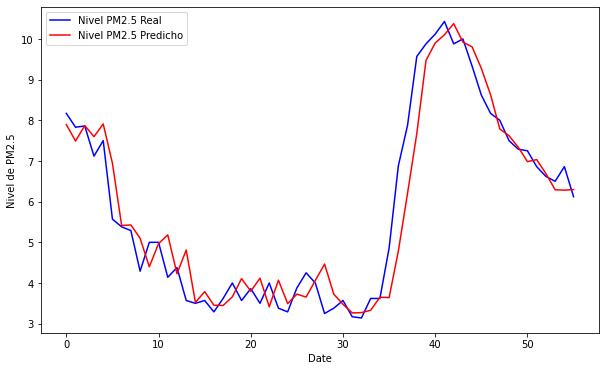

In [51]:
rmse_lr_10_pm25, mae_lr_10_pm25, preds_lr_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, LinearRegression())

Test Score Step 1
RMSE 0.64
MAE 0.45
Test Score Step 2
RMSE 0.65
MAE 0.46
Test Score Step 3
RMSE 0.69
MAE 0.50
Test Score Step 4
RMSE 0.69
MAE 0.48
Test Score Step 5
RMSE 0.68
MAE 0.47
Test Score Step 6
RMSE 0.68
MAE 0.48
Test Score Step 7
RMSE 0.67
MAE 0.46
Test Score Step 8
RMSE 0.68
MAE 0.46
Test Score Step 9
RMSE 0.67
MAE 0.47
Test Score Step 10
RMSE 0.68
MAE 0.48
Test Score Step 11
RMSE 0.71
MAE 0.51
Test Score Step 12
RMSE 0.74
MAE 0.53
Test Score Step 13
RMSE 0.73
MAE 0.51
Test Score Step 14
RMSE 0.71
MAE 0.50
Test Score Step 15
RMSE 0.71
MAE 0.50


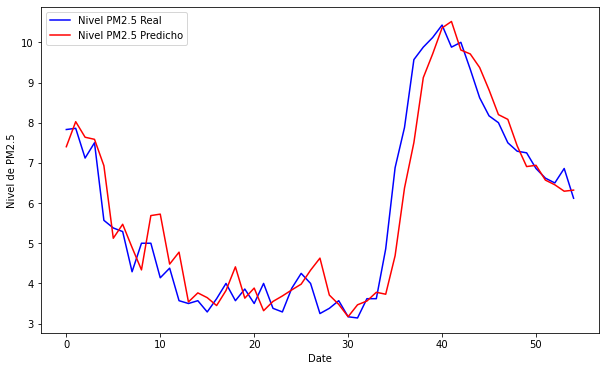

In [52]:
rmse_lr_15_pm25, mae_lr_15_pm25, preds_lr_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.03
MAE 0.82
Test Score Step 2
RMSE 1.04
MAE 0.84
Test Score Step 3
RMSE 1.05
MAE 0.85
Test Score Step 4
RMSE 1.05
MAE 0.84
Test Score Step 5
RMSE 1.05
MAE 0.84


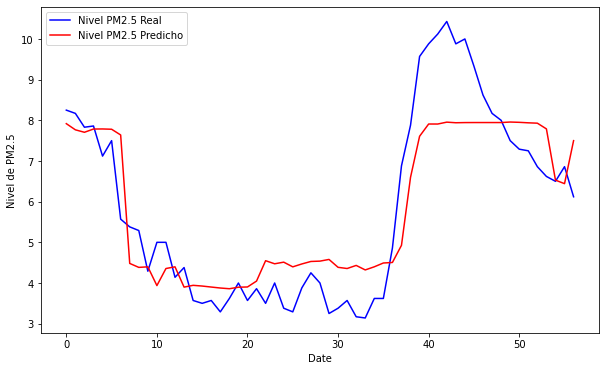

In [53]:
rmse_rf_5_pm25, mae_rf_5_pm25, preds_rf_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.13
MAE 0.90
Test Score Step 2
RMSE 1.14
MAE 0.91
Test Score Step 3
RMSE 1.14
MAE 0.93
Test Score Step 4
RMSE 1.14
MAE 0.93
Test Score Step 5
RMSE 1.14
MAE 0.93
Test Score Step 6
RMSE 1.13
MAE 0.92
Test Score Step 7
RMSE 1.13
MAE 0.92
Test Score Step 8
RMSE 1.13
MAE 0.92
Test Score Step 9
RMSE 1.14
MAE 0.92
Test Score Step 10
RMSE 1.13
MAE 0.92


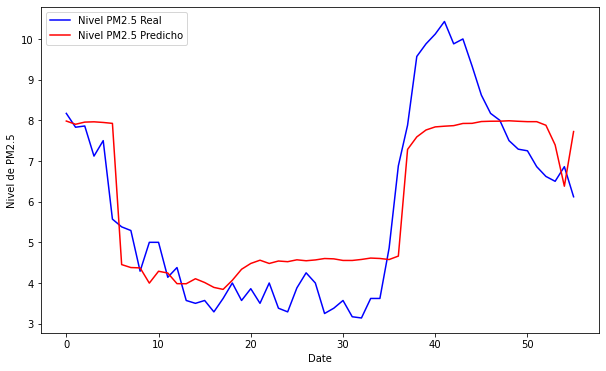

In [54]:
rmse_rf_10_pm25, mae_rf_10_pm25, preds_rf_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.24
MAE 0.98
Test Score Step 2
RMSE 1.24
MAE 0.98
Test Score Step 3
RMSE 1.24
MAE 0.99
Test Score Step 4
RMSE 1.23
MAE 0.98
Test Score Step 5
RMSE 1.23
MAE 0.98
Test Score Step 6
RMSE 1.22
MAE 0.98
Test Score Step 7
RMSE 1.22
MAE 0.98
Test Score Step 8
RMSE 1.22
MAE 0.98
Test Score Step 9
RMSE 1.21
MAE 0.98
Test Score Step 10
RMSE 1.21
MAE 0.98
Test Score Step 11
RMSE 1.21
MAE 0.98
Test Score Step 12
RMSE 1.21
MAE 0.98
Test Score Step 13
RMSE 1.19
MAE 0.96
Test Score Step 14
RMSE 1.19
MAE 0.96
Test Score Step 15
RMSE 1.19
MAE 0.96


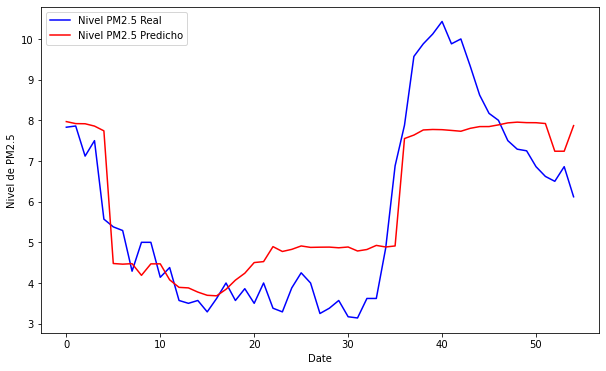

In [55]:
rmse_rf_15_pm25, mae_rf_15_pm25, preds_rf_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, RandomForestRegressor(random_state=seed_value))

# PM10

In [56]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm10 = np.sum([len(re.findall("Lag_pm10*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm10], prueba_X_test.iloc[:,-lagspm10:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm10_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [57]:
def testPM10Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.2, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm10'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM10 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM10 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM10')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [58]:
df_final_pm10 = df_final[['temperature', 'relativehumidity', 'pm25', 'co2', 'pm10']]

In [59]:
df_lags_5_pm10 = lags(df_final_pm10, 5) #predecir a 5 minutos
df_lags_5_pm10 = df_lags_5_pm10.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,pm10
0,23.80,23.81,23.84,23.87,23.85,53.83,53.77,53.82,53.88,53.88,...,456.17,456.57,457.62,457.68,3.00,3.00,3.43,3.29,3.00,3.00
1,23.80,23.80,23.81,23.84,23.87,53.78,53.83,53.77,53.82,53.88,...,455.89,456.17,456.57,457.62,3.00,3.00,3.00,3.43,3.29,3.00
2,23.74,23.80,23.80,23.81,23.84,53.73,53.78,53.83,53.77,53.82,...,455.26,455.89,456.17,456.57,3.00,3.00,3.00,3.00,3.43,2.86
3,23.71,23.74,23.80,23.80,23.81,53.69,53.73,53.78,53.83,53.77,...,453.98,455.26,455.89,456.17,2.86,3.00,3.00,3.00,3.00,3.12
4,23.73,23.71,23.74,23.80,23.80,53.72,53.69,53.73,53.78,53.83,...,453.58,453.98,455.26,455.89,3.12,2.86,3.00,3.00,3.00,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,23.84,23.84,23.85,23.85,23.88,54.84,54.79,54.76,54.69,54.75,...,455.95,455.85,456.74,457.30,8.25,8.29,8.50,9.00,9.17,7.86
279,23.80,23.84,23.84,23.85,23.85,54.93,54.84,54.79,54.76,54.69,...,456.20,455.95,455.85,456.74,7.86,8.25,8.29,8.50,9.00,7.62
280,23.81,23.80,23.84,23.84,23.85,54.90,54.93,54.84,54.79,54.76,...,456.89,456.20,455.95,455.85,7.62,7.86,8.25,8.29,8.50,7.50
281,23.76,23.81,23.80,23.84,23.84,54.88,54.90,54.93,54.84,54.79,...,456.01,456.89,456.20,455.95,7.50,7.62,7.86,8.25,8.29,7.86


In [60]:
df_lags_10_pm10 = lags(df_final_pm10, 10) #predecir a 10 minutos
df_lags_10_pm10 = df_lags_10_pm10.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_pm10_6,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,pm10
0,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,23.85,...,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,3.00,2.86
1,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,23.87,...,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,2.75
2,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,23.84,...,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,2.75
3,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,23.81,...,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,2.43
4,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,23.80,...,2.75,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,8.29,8.50,9.00,9.17,9.62,10.33,11.00,10.88,11.43,7.86
274,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,8.25,8.29,8.50,9.00,9.17,9.62,10.33,11.00,10.88,7.62
275,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,7.86,8.25,8.29,8.50,9.00,9.17,9.62,10.33,11.00,7.50
276,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,7.62,7.86,8.25,8.29,8.50,9.00,9.17,9.62,10.33,7.86


In [61]:
df_lags_15_pm10 = lags(df_final_pm10, 15) #predecir a 15 minutos
df_lags_15_pm10 = df_lags_15_pm10.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,Lag_pm10_11,Lag_pm10_12,Lag_pm10_13,Lag_pm10_14,Lag_pm10_15,pm10
0,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,23.80,...,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,3.00,2.57
1,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,23.74,...,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,3.29,2.38
2,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,23.71,...,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,3.43,2.50
3,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,23.73,...,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,3.00,2.71
4,23.58,23.62,23.61,23.65,23.63,23.66,23.66,23.66,23.69,23.71,...,2.75,2.75,2.86,2.62,3.12,2.86,3.00,3.00,3.00,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,23.97,...,10.33,11.00,10.88,11.43,11.12,10.88,10.57,8.88,7.88,7.86
269,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,23.96,...,9.62,10.33,11.00,10.88,11.43,11.12,10.88,10.57,8.88,7.62
270,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,23.93,...,9.17,9.62,10.33,11.00,10.88,11.43,11.12,10.88,10.57,7.50
271,23.76,23.81,23.80,23.84,23.84,23.85,23.85,23.88,23.89,23.93,...,9.00,9.17,9.62,10.33,11.00,10.88,11.43,11.12,10.88,7.86


## Linear Regression

Test Score Step 1
RMSE 0.60
MAE 0.41
Test Score Step 2
RMSE 0.59
MAE 0.40
Test Score Step 3
RMSE 0.60
MAE 0.41
Test Score Step 4
RMSE 0.62
MAE 0.42
Test Score Step 5
RMSE 0.62
MAE 0.42


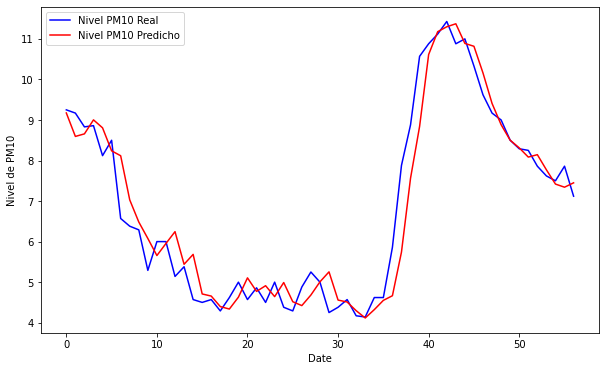

In [62]:
rmse_lr_5_pm10, mae_lr_5_pm10, preds_lr_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, LinearRegression())

Test Score Step 1
RMSE 0.62
MAE 0.43
Test Score Step 2
RMSE 0.61
MAE 0.43
Test Score Step 3
RMSE 0.63
MAE 0.44
Test Score Step 4
RMSE 0.65
MAE 0.44
Test Score Step 5
RMSE 0.64
MAE 0.44
Test Score Step 6
RMSE 0.64
MAE 0.44
Test Score Step 7
RMSE 0.64
MAE 0.44
Test Score Step 8
RMSE 0.65
MAE 0.45
Test Score Step 9
RMSE 0.65
MAE 0.45
Test Score Step 10
RMSE 0.66
MAE 0.45


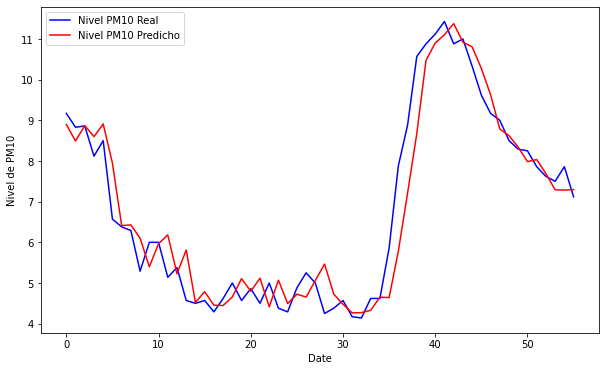

In [63]:
rmse_lr_10_pm10, mae_lr_10_pm10, preds_lr_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, LinearRegression())

Test Score Step 1
RMSE 0.64
MAE 0.45
Test Score Step 2
RMSE 0.65
MAE 0.46
Test Score Step 3
RMSE 0.69
MAE 0.50
Test Score Step 4
RMSE 0.69
MAE 0.48
Test Score Step 5
RMSE 0.68
MAE 0.47
Test Score Step 6
RMSE 0.68
MAE 0.48
Test Score Step 7
RMSE 0.67
MAE 0.46
Test Score Step 8
RMSE 0.68
MAE 0.46
Test Score Step 9
RMSE 0.67
MAE 0.47
Test Score Step 10
RMSE 0.68
MAE 0.48
Test Score Step 11
RMSE 0.71
MAE 0.51
Test Score Step 12
RMSE 0.74
MAE 0.53
Test Score Step 13
RMSE 0.73
MAE 0.51
Test Score Step 14
RMSE 0.71
MAE 0.50
Test Score Step 15
RMSE 0.71
MAE 0.50


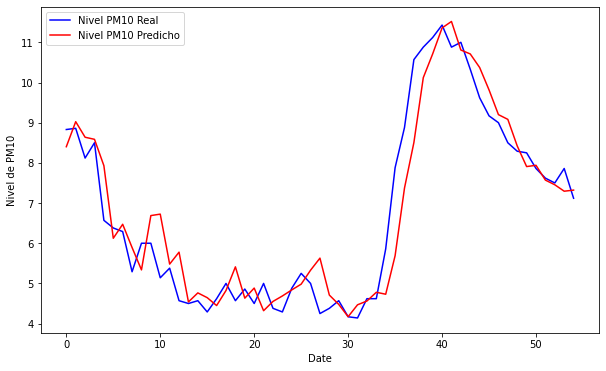

In [64]:
rmse_lr_15_pm10, mae_lr_15_pm10, preds_lr_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.06
MAE 0.84
Test Score Step 2
RMSE 1.07
MAE 0.86
Test Score Step 3
RMSE 1.08
MAE 0.87
Test Score Step 4
RMSE 1.08
MAE 0.87
Test Score Step 5
RMSE 1.08
MAE 0.87


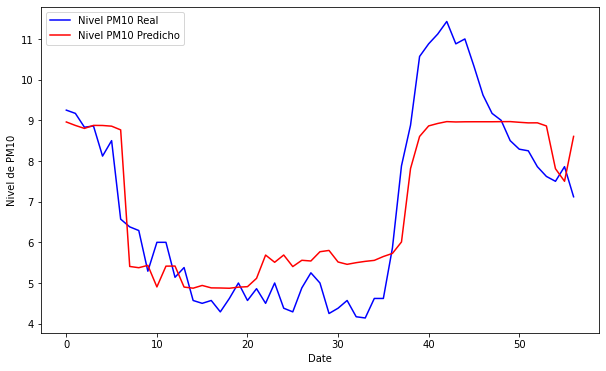

In [65]:
rmse_rf_5_pm10, mae_rf_5_pm10, preds_rf_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.16
MAE 0.93
Test Score Step 2
RMSE 1.16
MAE 0.94
Test Score Step 3
RMSE 1.16
MAE 0.95
Test Score Step 4
RMSE 1.16
MAE 0.94
Test Score Step 5
RMSE 1.15
MAE 0.94
Test Score Step 6
RMSE 1.15
MAE 0.94
Test Score Step 7
RMSE 1.15
MAE 0.94
Test Score Step 8
RMSE 1.15
MAE 0.94
Test Score Step 9
RMSE 1.15
MAE 0.94
Test Score Step 10
RMSE 1.14
MAE 0.93


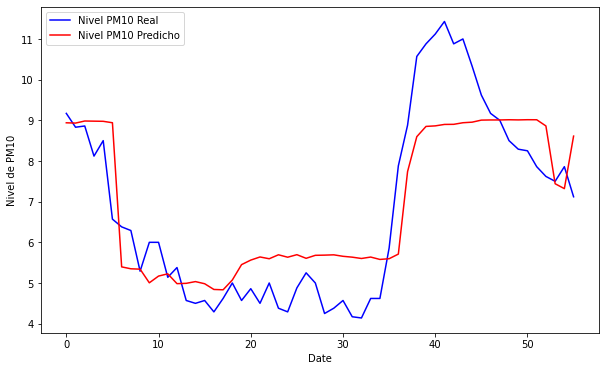

In [66]:
rmse_rf_10_pm10, mae_rf_10_pm10, preds_rf_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 1.19
MAE 0.94
Test Score Step 2
RMSE 1.18
MAE 0.94
Test Score Step 3
RMSE 1.20
MAE 0.96
Test Score Step 4
RMSE 1.20
MAE 0.96
Test Score Step 5
RMSE 1.20
MAE 0.97
Test Score Step 6
RMSE 1.20
MAE 0.96
Test Score Step 7
RMSE 1.19
MAE 0.96
Test Score Step 8
RMSE 1.19
MAE 0.96
Test Score Step 9
RMSE 1.19
MAE 0.97
Test Score Step 10
RMSE 1.19
MAE 0.97
Test Score Step 11
RMSE 1.19
MAE 0.97
Test Score Step 12
RMSE 1.18
MAE 0.97
Test Score Step 13
RMSE 1.18
MAE 0.96
Test Score Step 14
RMSE 1.18
MAE 0.96
Test Score Step 15
RMSE 1.17
MAE 0.96


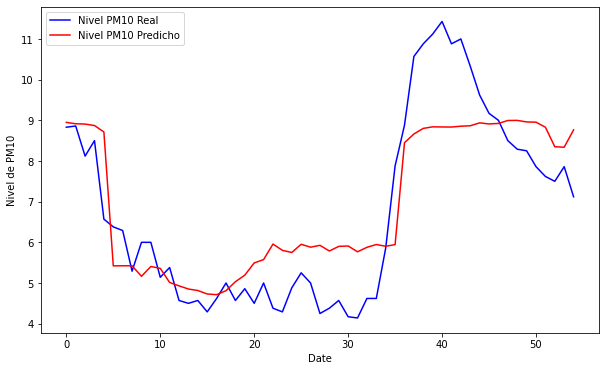

In [67]:
rmse_rf_15_pm10, mae_rf_15_pm10, preds_rf_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, RandomForestRegressor(random_state=seed_value))